# Load Image

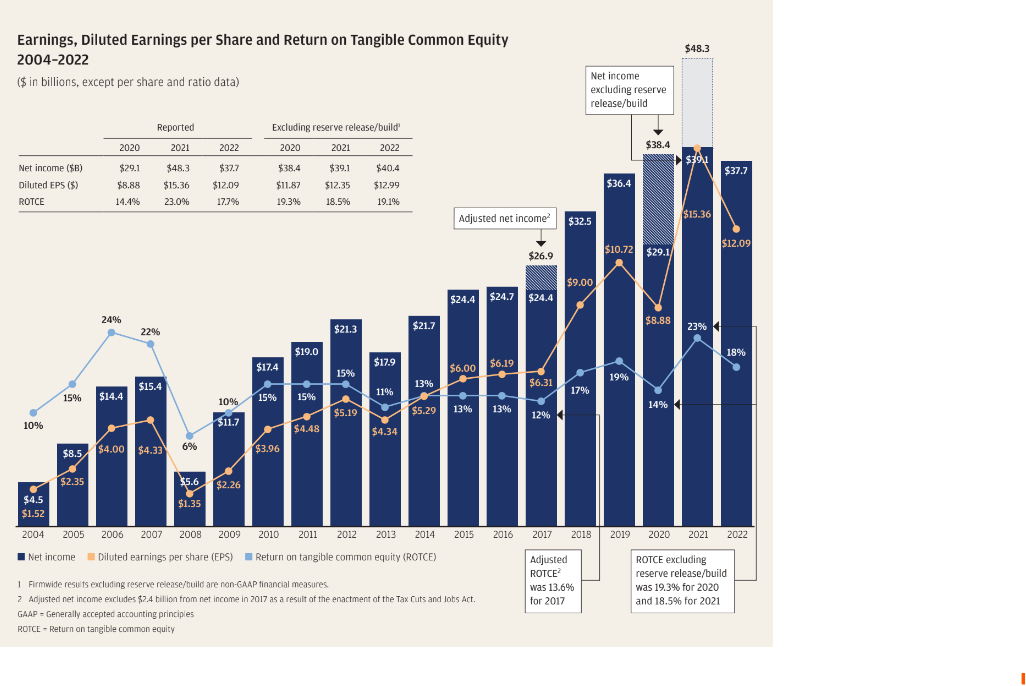

In [43]:
path_img = local_path+"page_1_table_chart.png"

from IPython.display import Image
Image(path_img)

# Evaluating O1’s Reasoning on Complex Financial Charts: How Well Can It Analyze Financial Data?

Extracting insights from financial charts isn't as easy as it seems. These charts often:

🔹 Contain multiple data points (e.g., earnings, EPS, ROTCE)

🔹 Combine bar charts, line graphs, and tables

🔹 Require context-aware reasoning (adjusted vs. reported figures)

🔹 Include annotations and footnotes affecting interpretation


## How Did O1 Performed compared to GPT-4o, Claude 3.5 Sonnet?
I tested three multimodal LLMs on a complex financial chart containing earnings data from 2004 to 2022. The models extracted numerical values and were evaluated against ground truth. Here's what we found:

(for o1, I used 2 techniques: 1/ Direct instruction to extract data from the image, and 2/ Detailed 2-step prompts to extract description and then figures)


1️⃣ GPT-4o

🔹  Fast extraction of structured JSON data

🔹 High accuracy in bar values

⚠️ Struggles with fine details (e.g., footnotes, adjusted figures)

⚠️ Minor misalignment in EPS values


2️⃣ O1 (With and Without Detailed Prompts)

🔹 Better accuracy with structured prompts

🔹 Detected more annotations than GPT-4o

⚠️ Struggled with line graph values

⚠️ Direct question method was less reliable



3️⃣ Claude 3.5 Sonnet

🏆 Best overall accuracy

🔹 Captured detailed adjustments in the chart

🔹 Strong understanding of footnotes & contextual insights

⚠️ Slightly slower response time compared to GPT-4o



## Final RMSE (Root Mean Squared Error) Scores 🔍

📉 Lower RMSE = More accurate extraction

🔹 Claude 3.5 Sonnet: 0.76 (Best)

🔹 O1 with a structured prompt: 1.28

🔹 O1 without structured prompts: 1.33

🔹 GPT-4o: 1.36 (Highest error)


##🚀 Key Takeaways
🔹 Claude 3.5 Sonnet delivered the most accurate results across the board.

🔹 O1 with structured prompts improved accuracy but still lagged behind Claude.

🔹 Direct O1 prompting was better than GPT-4o but still had misalignment issues.

🔹 GPT-4o was the fastest but made more extraction mistakes.


👉 Multimodal LLMs can extract data from financial charts, but accuracy varies significantly. While Claude 3.5 Sonnet currently leads in reasoning, prompting techniques still greatly affect results.


[Hanane DUPOUY](https://www.linkedin.com/in/hanane-d-algo-trader/)

In [ ]:
!pip install anthropic -q
# !pip install openai -q

# Encode Image on base64:

In [44]:
import io
import base64
from PIL import Image

images = [Image.open(f"{path_img}")]

base64_encoded_pngs = []
quality=75
max_size=(1024, 1024)
for image in images:
        if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
            image.thumbnail(max_size, Image.Resampling.LANCZOS)
        image_data = io.BytesIO()
        image.save(image_data, format='PNG', optimize=True, quality=quality)
        image_data.seek(0)
        base64_encoded = base64.b64encode(image_data.getvalue()).decode('utf-8')
        base64_encoded_pngs.append(base64_encoded)

In [47]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
CLAUDE_API_KEY = userdata.get('CLAUDE_API_KEY')

from openai import OpenAI
import anthropic

# Methods to call GPT-4o and o1:

In [49]:
client_openai = OpenAI(api_key=OPENAI_API_KEY)
# MODEL_NAME_GPT = "gpt-4o-mini"

def openai_completion(messages, model_name, json_mode=False):
    if json_mode:
      response = client_openai.chat.completions.create(
          model=model_name,
          messages=messages,
          response_format={ "type": "json_object" }
      )
      print(response.model)
    else:
      response = client_openai.chat.completions.create(
          model=model_name,
          messages=messages
           )
      print(response.model)
    return response

def append_message(content, question):
    content.append({"type": "text", "text": question})
    messages = [
      {
          "role": 'user',
          "content": content
      }
    ]
    return messages

# Multimdal LLM calls: Extract data from images:

## Chat with GPT-4o - Json Mode

In [ ]:
%%time
content = [{"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encoded_png}"}} for encoded_png in base64_encoded_pngs]
question = "Extract raw data from the image  in a JSON format."
messages_gpt = append_message(content, question)
MODEL_NAME_GPT = "gpt-4o"
response_4O = openai_completion(messages_gpt, MODEL_NAME_GPT, json_mode= True)
print(response_4O.choices[0].message.content)


# Time answering: 14.2s
# gpt-4o-2024-08-06

# {"data": {
#     "2004": {
#         "net_income": 4.5,
#         "diluted_eps": 1.52,
#         "rotce": 10
#     },
#     "2005": {
#         "net_income": 8.5,
#         "diluted_eps": 2.35,
#         "rotce": 14
#     },
#     "2006": {
#         "net_income": 14.4,
#         "diluted_eps": 4.06,
#         "rotce": 24
#     },
#     "2007": {
#         "net_income": 15.4,
#         "diluted_eps": 4.33,
#         "rotce": 22
#     },
# ..............
# ..............
#       "notes": {
#     "adjusted_net_income_2017": 2.4,
#     "adjusted_rotce_2017": 13.6,
#     "rotce_excluding_reserve_2020": 19.3,
#     "rotce_excluding_reserve_2021": 18.5
#   }
# }
# CPU times: user 96 ms, sys: 8.24 ms, total: 104 ms
# Wall time: 14.2 s

In [56]:
resp_4O = response_4O.choices[0].message.content
resp_4O = resp_4O.strip("'")
json_data_4O = json.loads(resp_4O)
df_4O = pd.DataFrame(json_data_4O["data"]).T
df_4O = df_4O.reset_index()
# df_4O.columns=['year','net_income_billion', 'diluted_eps', 'rotce_percent']
df_4O

df_4O.head()

,year,net_income_billion,diluted_eps,rotce_percent
0,2004,4.5,1.52,10.0
1,2005,8.5,2.35,14.0
2,2006,14.4,4.06,24.0
3,2007,15.4,4.33,22.0
4,2008,-0.4,-0.06,6.0


## Chat with o1: Direct question to extract data

In this experiment, I asked o1 to extract the whole data.

<font color='green'> The answer is well structured and it seems to have detected various comments in the figures. </font>

<font color='red'>
The bar values are well extracted, however it struggeled with lines values especially the Diluted EPS values.</font>

In [50]:
%%time
content = [{"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encoded_png}"}} for encoded_png in base64_encoded_pngs]
question = "Extract raw data from the image."
messages_gpt = append_message(content, question)
model_o1 = "o1"
response_o1_direct2 = openai_completion(messages_gpt, model_o1)
print(response_o1_direct2.choices[0].message.content)

o1-2024-12-17
Below is a year‐by‐year transcription of the main numerical data visible in the chart. All dollar figures for net income are in billions; EPS (earnings per share) is in dollars; and ROTCE (return on tangible common equity) is in percent. Where the chart provides both “reported” and “excluding reserve release/build” figures (2020–2022), both are listed.

────────────────────────────────────────────────────────────────────────
  1) Historical GAAP/Reported Figures (2004–2022)
────────────────────────────────────────────────────────────────────────
 Year   Net Income ($B)   Diluted EPS ($)   ROTCE (%)
 ─────────────────────────────────────────────────────
 2004        4.5              1.52            10
 2005        8.5              2.35            14
 2006       14.4              4.33            24
 2007       15.4              5.26            22
 2008        5.6              1.35             6
 2009       11.7              2.26            15
 2010       17.4              3

In [54]:
%%time
content = [{"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encoded_png}"}} for encoded_png in base64_encoded_pngs]
question = "What was the net income in 2020? Provide the reasoning path before answering the question."
messages_gpt = append_message(content, question)
model_o1 = "o1"
response_o1_direct2 = openai_completion(messages_gpt, model_o1)
print(response_o1_direct2.choices[0].message.content)

o1-2024-12-17
Answer: The net income in 2020 is shown as $29.1 billion.

Explanation (concise): By examining the bar labeled “2020” in the chart’s net income column (the dark blue bars) and the accompanying table, the figure provided for 2020 net income is $29.1 billion.
CPU times: user 85.4 ms, sys: 10.3 ms, total: 95.6 ms
Wall time: 8.63 s


**<font color='purple'>In the following, I'll ask o1 to output a structured json format so I can compare these results with GPT-4O, Claude 3.5 Sonnet and the truth value: </font>**

## Chat with o1: Direct question with json output

* Here, I asked a  <font color='purple'>**direct question** </font> to extract the data from the image using json format.


* In the next paragraph "Detailed prompting method" I'll follow another way or prompting o1.

In [ ]:
%%time
content = [{"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encoded_png}"}} for encoded_png in base64_encoded_pngs]
question = "Extract raw data from the image in a JSON format."
messages_gpt = append_message(content, question)
model_o1 = "o1"
response_o1_direct_json = openai_completion(messages_gpt, model_o1, json_mode=True)
print(response_o1_direct_json.choices[0].message.content)

# o1-2024-12-17
# {
#   "data": [
#     {
#       "year": 2004,
#       "net_income_reported_b": 4.5,
#       "diluted_eps_reported": 1.52,
#       "rotce_reported_percent": 10,
#       "net_income_excluding_reserve_release_build_b": null,
#       "diluted_eps_excluding_reserve_release_build": null,
#       "rotce_excluding_reserve_release_build_percent": null,
#       "adjusted_net_income_b": null,
#       "adjusted_rotce_percent": null
#     },
#     {
#       "year": 2005,
#       "net_income_reported_b": 8.5,
#       "diluted_eps_reported": 2.35,
#       "rotce_reported_percent": 15,
#       "net_income_excluding_reserve_release_build_b": null,
#       "diluted_eps_excluding_reserve_release_build": null,
#       "rotce_excluding_reserve_release_build_percent": null,
#       "adjusted_net_income_b": null,
#       "adjusted_rotce_percent": null
#     },
# ............
#   ],
#   "footnotes": [
#     "1. Firmwide results excluding reserve release/build are non-GAAP financial measures.",
#     "2. Adjusted net income includes $2.4 billion from net income in 2017 as a result of the enactment of the Tax Cuts and Jobs Act.",
#     "GAAP = Generally accepted accounting principles",
#     "ROTCE = Return on tangible common equity",
#     "Adjusted ROTCE for 2017 was 13.6%",
#     "ROTCE excluding reserve release/build was 19.3% for 2020 and 18.5% for 2021"
#   ]
# }
# CPU times: user 395 ms, sys: 63.2 ms, total: 458 ms
# Wall time: 1min 6s

In [58]:
resp_o1_direct = response_o1_direct_json.choices[0].message.content
resp_o1_direct = resp_o1_direct.strip("'")
json_data_o1 = json.loads(resp_o1_direct)
df_o1_direct = pd.DataFrame(json_data_o1["data"])
df_o1_direct.tail()

,year,net_income_reported_b,diluted_eps_reported,rotce_reported_percent,net_income_excluding_reserve_release_build_b,diluted_eps_excluding_reserve_release_build,rotce_excluding_reserve_release_build_percent,adjusted_net_income_b,adjusted_rotce_percent
14,2018,32.5,9.00,17,NaN,NaN,NaN,NaN,NaN
15,2019,36.4,10.72,19,NaN,NaN,NaN,NaN,NaN
16,2020,29.1,8.88,14,38.4,11.87,19.3,NaN,NaN
17,2021,48.3,15.36,23,33.1,12.35,18.5,NaN,NaN
18,2022,37.7,12.09,18,40.4,12.99,19.1,NaN,NaN


## Chat with o1: Detailed prompting method

* First I ask for image's description:

In [ ]:
%%time
content = [{"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encoded_png}"}} for encoded_png in base64_encoded_pngs]
question = """
<instructions> You are a financial analyst who is very precise when describing information included in tables and graphs.
- Describe any tables or charts you see in the image.
- This description must be conscise and accurate.
- Provide the description in bullet point that we can use as the base structure for a json format.
</instructions>
"""
messages_gpt = append_message(content, question)
model_reasoning = "o1"
response = openai_completion(messages_gpt, model_reasoning)
print(response.choices[0].message.content)

o1-2024-12-17
• A title notes “Earnings, Diluted Earnings per Share and Return on Tangible Common Equity (2004–2022).”  
• A vertical bar chart displays annual Net Income (in billions of dollars) from 2004 through 2022.  
• An orange line (overlaid on the bar chart) shows annual Diluted Earnings per Share.  
• A blue line (or labeled points) indicates annual ROTCE percentages.  
• A small table (upper left) compares “Reported” vs. “Excluding reserve release/build” figures for 2020–2022, showing:  
   – Net income (in billions),  
   – Diluted EPS,  
   – ROTCE (both reported and adjusted).  
CPU times: user 137 ms, sys: 16.6 ms, total: 153 ms
Wall time: 19.4 s


In [39]:
# description = response.choices[0].message.content
description_image = """
• A title notes “Earnings, Diluted Earnings per Share and Return on Tangible Common Equity (2004–2022).”
• A vertical bar chart displays annual Net Income (in billions of dollars) from 2004 through 2022.
• An orange line (overlaid on the bar chart) shows annual Diluted Earnings per Share.
• A blue line (or labeled points) indicates annual ROTCE percentages.
• A small table (upper left) compares “Reported” vs. “Excluding reserve release/build” figures for 2020–2022, showing:
   – Net income (in billions),
   – Diluted EPS,
   – ROTCE (both reported and adjusted).
"""

* Second ask to extract data from images and add description to the prompt: (without json mode)

In [ ]:
%%time
content = [{"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encoded_png}"}} for encoded_png in base64_encoded_pngs]
# question = "Extract raw data from the image. Be carreful to extract the right values from x axis, and the accurate corresponding "
question = f"""
<instructions> You are a financial analyst who is very precise when extracting figures from graphs.
- Extract raw data from the image. Be carreful to extract the right values from x axis, and the accurate corresponding values from y axis.
</instructions>
<description>
- Here is a description of the tables and charts included in the image:
{description_image}
</description
"""
messages_gpt = append_message(content, question)
model_reasoning = "o1"
response2 = openai_completion(messages_gpt, model_reasoning)
print(response2.choices[0].message.content)

# o1-2024-12-17
# Below is the numerical detail as it appears in the chart and small table.  All dollar amounts are in billions (for Net Income) or dollars (for EPS); ROTCE is in percent.

# ────────────────────────────────────────────────────
# 1) Annual “Reported” Net Income, EPS, and ROTCE
# ────────────────────────────────────────────────────
# • 2004:
#   – Net Income: $4.5
#   – Diluted EPS: $1.52
#   – ROTCE: 10%

# • 2005:
#   – Net Income: $8.5
#   – Diluted EPS: $2.35
#   – ROTCE: 14%

# • 2006:
#   – Net Income: $14.4
#   – Diluted EPS: $4.04
#   – ROTCE: 24%

# • 2007:
#   – Net Income: $15.3 (approx.)
#   – Diluted EPS: $4.33
#   – ROTCE: 22%
# ....
# ─────────────────────────────────────────────
# 2) “Excluding Reserve Release/Build” (2020–22)
# ─────────────────────────────────────────────
# • 2020 (Excl. reserve release/build)
#   – Net Income: $38.4
#   – Diluted EPS: $11.87
#   – ROTCE: 19.3%

# • 2021 (Excl. reserve release/build)
#   – Net Income: $33.1
#   – Diluted EPS: $12.35
#   – ROTCE: 18.5%

# • 2022 (Excl. reserve release/build)
#   – Net Income: $40.4
#   – Diluted EPS: $12.99
#   – ROTCE: 19.1%
# CPU times: user 516 ms, sys: 65.8 ms, total: 582 ms
# Wall time: 1min 32s

* Second ask to extract data from images and add description to the prompt in json mode:

In [ ]:
%%time
content = [{"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encoded_png}"}} for encoded_png in base64_encoded_pngs]
# question = "Extract raw data from the image. Be carreful to extract the right values from x axis, and the accurate corresponding "
question = f"""
<instructions> You are a financial analyst who is very precise when extracting figures from graphs.
- Extract raw data from the image in a JSON format. Be carreful to extract the right values from x axis, and the accurate corresponding values from y axis.
</instructions>
<description>
- Here is a description of the tables and charts included in the image:
{description_image}
</description
"""
messages_gpt = append_message(content, question)
model_reasoning = "o1"
response_o1 = openai_completion(messages_gpt, model_reasoning,json_mode = True)
print(response_o1.choices[0].message.content)

# o1-2024-12-17
# {
#   "data_by_year": [
#     {
#       "year": 2004,
#       "net_income_billions": 4.5,
#       "diluted_eps": 1.52,
#       "rotce_percent": 10
#     },
#     {
#       "year": 2005,
#       "net_income_billions": 8.5,
#       "diluted_eps": 2.35,
#       "rotce_percent": 15
#     },
# ....
#         {
#       "year": 2022,
#       "net_income_billions_reported": 37.7,
#       "net_income_billions_ex_reserve": 40.4,
#       "diluted_eps_reported": 12.09,
#       "diluted_eps_ex_reserve": 12.99,
#       "rotce_percent_reported": 18,
#       "rotce_percent_ex_reserve": 19.1
#     }
#   ]
# }
# CPU times: user 662 ms, sys: 86 ms, total: 748 ms
# Wall time: 2min 16s

I load the json data as a dataframe (to be used later)

In [52]:
import json
import pandas as pd

resp_o1 = response_o1.choices[0].message.content
resp_o1 = resp_o1.strip("'")
json_data_o1 = json.loads(resp_o1)
df_o1 = pd.DataFrame(json_data_o1["data_by_year"])
df_o1.tail()

,year,net_income_billions,diluted_eps,rotce_percent,rotce_percent_reported,rotce_percent_adjusted,net_income_billions_reported,net_income_billions_ex_reserve,diluted_eps_reported,diluted_eps_ex_reserve,rotce_percent_ex_reserve
14,2018,32.5,9.00,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,2019,36.4,10.72,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,2020,NaN,NaN,NaN,14.4,NaN,29.1,38.4,8.88,11.57,19.3
17,2021,NaN,NaN,NaN,23.0,NaN,48.3,33.1,15.36,11.87,18.5
18,2022,NaN,NaN,NaN,18.0,NaN,37.7,40.4,12.09,12.99,19.1


In [53]:
df_o1['net_income_billions'] = df_o1['net_income_billions'].fillna(df_o1['net_income_billions_reported'])
df_o1['diluted_eps'] = df_o1['diluted_eps'].fillna(df_o1['diluted_eps_reported'])
df_o1['rotce_percent'] = df_o1['rotce_percent'].fillna(df_o1['rotce_percent_reported'])
df_o1 = df_o1[['year', 'net_income_billions', 'diluted_eps', 'rotce_percent']]
df_o1

,year,net_income_billions,diluted_eps,rotce_percent
0,2004,4.5,1.52,10.0
1,2005,8.5,2.35,15.0
2,2006,14.4,3.56,24.0
3,2007,15.4,4.33,22.0
4,2008,5.6,1.35,6.0
5,2009,11.7,2.26,9.0
6,2010,17.4,3.96,15.0
7,2011,19.0,4.48,15.0
8,2012,21.3,5.20,15.0
9,2013,17.9,4.34,14.0


## Chat with Claude 3.5 Sonnet

I tried the samething with Claude 3.5 Sonnet

In [11]:
client_claude = anthropic.Anthropic(
    api_key=CLAUDE_API_KEY,
)

MODEL_NAME = "claude-3-5-sonnet-20240620"
def get_completion_claude(messages):
    response = client_claude.messages.create(
        model=MODEL_NAME,
        max_tokens=2048,
        # temperature=0,
        messages=messages
    )
    print(response.model)
    return response.content[0].text

In [ ]:
%%time
content = [{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": encoded_png}} for encoded_png in base64_encoded_pngs]
question = "Extract raw data information from the images as a JSON format. Only output the JSON and nothing else."
messages_claude = append_message(content, question)
MODEL_NAME = "claude-3-5-sonnet-latest"
chart_analysis = get_completion_claude(messages_claude)
print(chart_analysis)


# claude-3-5-sonnet-20241022
# {
#   "earnings_data": {
#     "2004": {
#       "net_income": 4.5,
#       "diluted_eps": 1.52,
#       "rotce": 10
#     },
#     "2005": {
#       "net_income": 8.5,
#       "diluted_eps": 2.35,
#       "rotce": 15
#     },
#     "2006": {
#       "net_income": 14.4,
#       "diluted_eps": 4.00,
#       "rotce": 24
#     },
#     "2007": {
#       "net_income": 15.4,
#       "diluted_eps": 4.33,
#       "rotce": 22
#     },
#     "2008": {
#       "net_income": 5.6,
#       "diluted_eps": 1.35,
#       "rotce": 6
#     },
# ..........
#    "2022": {
#       "net_income": 40.4,
#       "diluted_eps": 12.09,
#       "rotce": 19.1
#     }
#   }
# }
# CPU times: user 111 ms, sys: 10.7 ms, total: 121 ms
# Wall time: 15.2 s

In [61]:
resp_claude = chart_analysis
resp_claude = resp_claude.strip("'")
json_data_claude = json.loads(resp_claude)
df_claude = pd.DataFrame(json_data_claude["earnings_data"]).T
df_claude

,net_income,diluted_eps,rotce
2004,4.5,1.52,10.0
2005,8.5,2.35,15.0
2006,14.4,4.00,24.0
2007,15.4,4.33,22.0
2008,5.6,1.35,6.0
2009,11.7,2.26,10.0
2010,17.4,4.48,15.0
2011,19.0,3.96,15.0
2012,21.3,5.19,15.0
2013,17.9,4.34,11.0


# Merge data extracted from GPT-4O and o1 to compare with Truth:

In [62]:
df_4O.columns=['year','net_income_billion', 'diluted_eps', 'rotce_percent']
print(df_o1.columns)

df_claude = df_claude.reset_index()
print(df_claude.columns)
df_claude.columns = ['year', 'net_income_billion', 'diluted_eps', 'rotce_percent']
print(df_claude.columns)

df_o1_direct = df_o1_direct[['year','net_income_reported_b','diluted_eps_reported','rotce_reported_percent']]
df_o1_direct.columns = ['year','net_income_billion', 'diluted_eps', 'rotce_percent']

Index(['year', 'net_income_billions', 'diluted_eps', 'rotce_percent'], dtype='object')
Index(['index', 'net_income', 'diluted_eps', 'rotce'], dtype='object')
Index(['year', 'net_income_billion', 'diluted_eps', 'rotce_percent'], dtype='object')


In [63]:
import json
import pandas as pd

#Truth value:
years = df_4O['year'].values
net_income = [ 4.5,  8.5, 14.4, 15.4,  5.6, 11.7, 17.4, 19. , 21.3, 17.9, 21.7, 24.4, 24.7, 24.4, 32.5, 36.4, 29.1, 39.1, 37.7]
diluted_eps = [1.52, 2.35,  4.0,  4.33,  1.35,  2.26,  3.96,  4.48,  5.19 , 4.34,  5.29,  6.  ,  6.19,  6.31,  9.  , 10.72,  8.88, 15.36, 12.09]
rotce_percent = [10, 15, 24, 22,  6, 10, 15, 15, 15, 11, 13, 13, 13, 12, 17, 19, 14, 23, 18]
df_true_data = pd.DataFrame({'year': years, 'net_income_billion': net_income, 'diluted_eps': diluted_eps, 'rotce_percent': rotce_percent})


from functools import reduce

dfs = [(df_o1, "_o1"), (df_o1_direct,"_o1_direct"), (df_4O, "_4O"), (df_claude, "_claude")]

df_merge = df_true_data

for df, suffix in dfs:
    df_merge = df_merge.merge(df, on='year', how='inner', suffixes=("", suffix) if suffix else (None, None))

df_merge.head()

,year,net_income_billion,diluted_eps,rotce_percent,net_income_billion_o1,diluted_eps_o1,rotce_percent_o1,net_income_billion_o1_direct,diluted_eps_o1_direct,rotce_percent_o1_direct,net_income_billion_4O,diluted_eps_4O,rotce_percent_4O,net_income_billion_claude,diluted_eps_claude,rotce_percent_claude
0,2004,4.5,1.52,10,4.5,1.52,10.0,4.5,1.52,10,4.5,1.52,10.0,4.5,1.52,10.0
1,2005,8.5,2.35,15,8.5,2.35,15.0,8.5,2.35,15,8.5,2.35,14.0,8.5,2.35,15.0
2,2006,14.4,4.00,24,14.4,3.56,24.0,14.4,3.82,24,14.4,4.06,24.0,14.4,4.00,24.0
3,2007,15.4,4.33,22,15.4,4.33,22.0,15.4,4.33,22,15.4,4.33,22.0,15.4,4.33,22.0
4,2008,5.6,1.35,6,5.6,1.35,6.0,5.6,1.35,6,-0.4,-0.06,6.0,5.6,1.35,6.0


## Compute RMSE: Rooth Mean Squared Errors

In [64]:
import pandas as pd
import numpy as np

cols_true = df_true_data.columns
measures = []

for idx, col in enumerate(cols_true[1:]):
  print(col)
  rmse_4O = np.sqrt(((df_merge[col+'_4O'] - df_merge[col]) ** 2).mean())
  rmse_o1 = np.sqrt(((df_merge[col+'_o1'] - df_merge[col]) ** 2).mean())
  rmse_o1_direct= np.sqrt(((df_merge[col+'_o1_direct'] - df_merge[col]) ** 2).mean())
  rmse_claude = np.sqrt(((df_merge[col+'_claude'] - df_merge[col]) ** 2).mean())

  print(f"RMSE for {col+'_4O'}:", rmse_4O)
  print(f"RMSE for {col+'_o1'}:", rmse_o1)
  print(f"RMSE for {col+'_o1_direct'}:", rmse_o1_direct)
  print(f"RMSE for {col+'_claude'}:", rmse_claude)

  measures.append([col,rmse_4O,rmse_o1,rmse_o1_direct,rmse_claude])

net_income_billion
RMSE for net_income_billion_4O: 2.5198162004817974
RMSE for net_income_billion_o1: 2.1106247516091674
RMSE for net_income_billion_o1_direct: 2.1106247516091674
RMSE for net_income_billion_claude: 2.1106247516091674
diluted_eps
RMSE for diluted_eps_4O: 0.3852545296704231
RMSE for diluted_eps_o1: 0.16570423874132525
RMSE for diluted_eps_o1_direct: 0.6191250192599911
RMSE for diluted_eps_claude: 0.1687102779759932
rotce_percent
RMSE for rotce_percent_4O: 1.1920791213585393
RMSE for rotce_percent_o1: 1.57546985472839
RMSE for rotce_percent_o1_direct: 1.2773327473170102
RMSE for rotce_percent_claude: 0.0


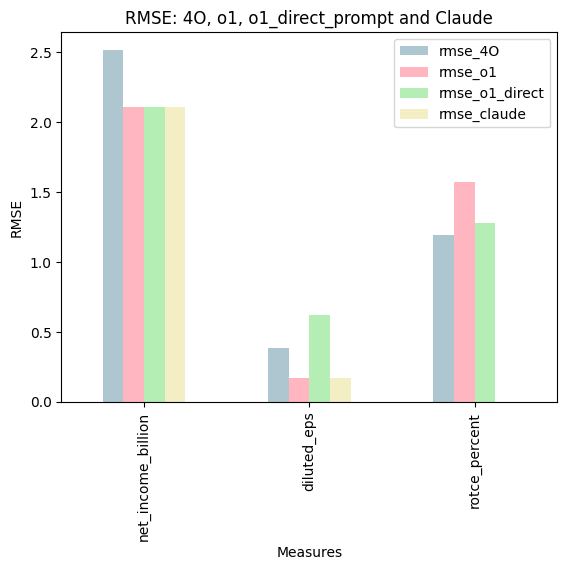

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_palette("pastel")

pastel_colors = ["#AEC6CF", "#FFB6C1", "#B4EEB4", "#F4EEC5"]
df_measure = pd.DataFrame(data=measures, columns=['measure','rmse_4O','rmse_o1','rmse_o1_direct','rmse_claude'])
df_measure.set_index('measure').plot(kind='bar', color=pastel_colors)
plt.title("RMSE: 4O, o1, o1_direct_prompt and Claude")
plt.xlabel("Measures")
plt.ylabel("RMSE")
plt.show()

In [68]:
df_measure

,measure,rmse_4O,rmse_o1,rmse_o1_direct,rmse_claude
0,net_income_billion,2.519816,2.110625,2.110625,2.110625
1,diluted_eps,0.385255,0.165704,0.619125,0.168710
2,rotce_percent,1.192079,1.575470,1.277333,0.000000


In [78]:
total_values = df_measure.set_index("measure").mean()
print(total_values)

total_values/total_values['rmse_claude']-1

rmse_4O           1.365717
rmse_o1           1.283933
rmse_o1_direct    1.335694
rmse_claude       0.759778
dtype: float64


,0
rmse_4O,0.797520
rmse_o1,0.689878
rmse_o1_direct,0.758005
rmse_claude,0.000000


# **<font color='purple'>Key Takeaways</font>**


* Claude 3.5 Sonnet delivers the best results among the models for extracting financial data from complex charts.

* O1 with a detailed prompt performs well but is noticeably behind Claude.

* Direct O1 (without a detailed prompt) also shows better results than 40, which ranks the lowest.

## Plot Difference

In [69]:
df_merge['error_net_income_o1'] = df_merge['net_income_billion_o1'] - df_merge['net_income_billion']
df_merge['error_diluted_eps_o1'] = df_merge['diluted_eps_o1'] - df_merge['diluted_eps']
df_merge['error_rotce_percent_o1'] = df_merge['rotce_percent_o1'] - df_merge['rotce_percent']

df_merge['error_net_income_o1_direct'] = df_merge['net_income_billion_o1_direct'] - df_merge['net_income_billion']
df_merge['error_diluted_eps_o1_direct'] = df_merge['diluted_eps_o1_direct'] - df_merge['diluted_eps']
df_merge['error_rotce_percent_o1_direct'] = df_merge['rotce_percent_o1_direct'] - df_merge['rotce_percent']

df_merge['error_net_income_4O'] = df_merge['net_income_billion_4O'] - df_merge['net_income_billion']
df_merge['error_diluted_eps_4O'] = df_merge['diluted_eps_4O'] - df_merge['diluted_eps']
df_merge['error_rotce_percent_4O'] = df_merge['rotce_percent_4O'] - df_merge['rotce_percent']

df_merge['error_net_income_claude'] = df_merge['net_income_billion_claude'] - df_merge['net_income_billion']
df_merge['error_diluted_eps_claude'] = df_merge['diluted_eps_claude'] - df_merge['diluted_eps']
df_merge['error_rotce_percent_claude'] = df_merge['rotce_percent_claude'] - df_merge['rotce_percent']

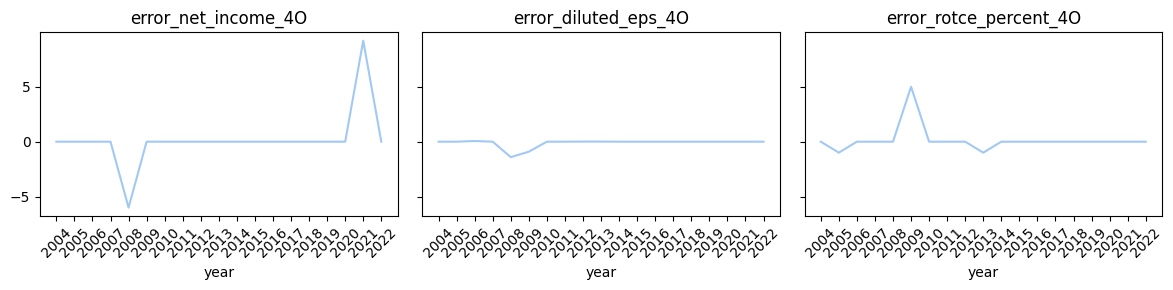

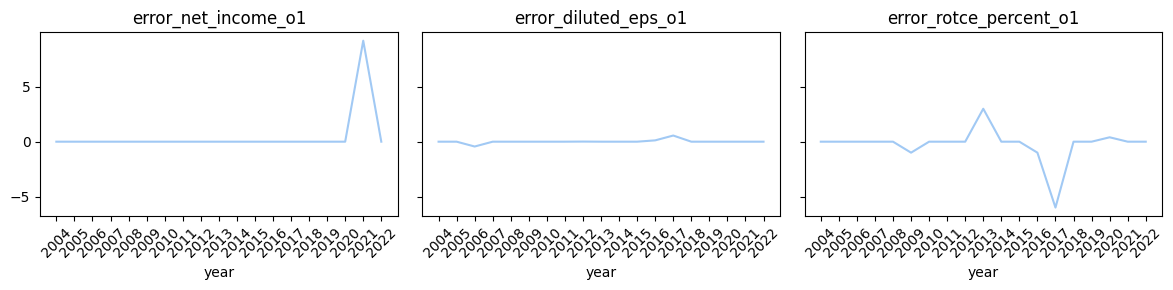

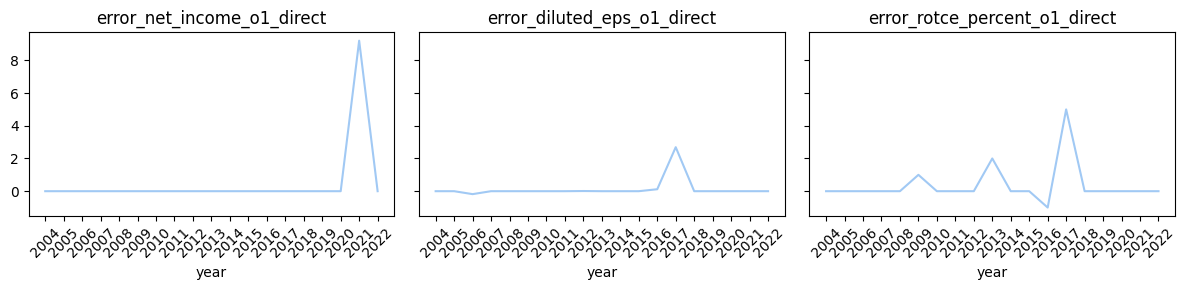

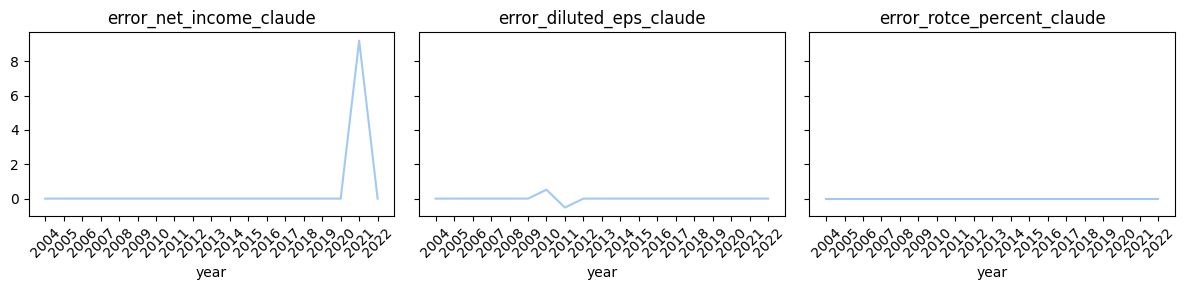

In [70]:
import matplotlib.pyplot as plt

# Define the columns to plot
cols_4O = ['error_net_income_4O', 'error_diluted_eps_4O', 'error_rotce_percent_4O']
cols_o1 = ['error_net_income_o1', 'error_diluted_eps_o1', 'error_rotce_percent_o1']
cols_o1_direct = ['error_net_income_o1_direct', 'error_diluted_eps_o1_direct', 'error_rotce_percent_o1_direct']
cols_claude = ['error_net_income_claude', 'error_diluted_eps_claude', 'error_rotce_percent_claude']

cols=[cols_4O, cols_o1, cols_o1_direct, cols_claude]

for col_model in cols:
  fig, axes = plt.subplots(1, len(col_model), figsize=(12,3), sharey=True)

  for i, col in enumerate(col_model):
      ax = axes[i]  # Select subplot
      df_merge.set_index('year')[col].plot(ax=ax)

      ax.set_xticks(df_merge['year'])
      ax.set_xticklabels(df_merge['year'].astype(int), rotation=45)
      ax.set_title(col)

  plt.tight_layout()

  plt.show()